# COVID-19 Analysis: Human Development Index vs True Pandemic Impact

## Research Question
Does overall societal development protect against pandemic mortality?

## Information Theory Context
This analysis explores a **non-obvious relationship** where the outcome is not immediately predictable. 
According to information theory, information content is inversely proportional to the probability of an outcome: 
**I ∝ 1/P(outcome)**. Surprising results contain more information than expected ones.

**Independent Variable**: `human_development_index`  
**Dependent Variable**: `excess_mortality_cumulative_per_million`  
**Analysis Type**: Cross Sectional

---


## Prevailing Narrative

The **Human Development Index** (combining health, education, and income indicators) was often invoked as a composite measure of societal capacity to handle crises. Highly developed nations were expected to leverage their advantages—education systems, healthcare infrastructure, governance capacity, and public trust—to achieve substantially better pandemic outcomes than less developed countries.

### Working Hypothesis
Based on this prevailing narrative, we would expect: **strong negative** correlation between 
`human_development_index` and `excess_mortality_cumulative_per_million`.  
In plain language: Higher human development should correlate with lower excess mortality

### Sources
- UNDP Human Development Reports\n- Pre-pandemic pandemic preparedness indices

---


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import sys

# Add project root to path and import config
project_root = Path('.').resolve().parent
sys.path.insert(0, str(project_root))
import config

# Set visualization defaults
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Data path using config
data_path = project_root / config.data_dir / 'owid-covid-data.csv'
print(f'Data source: {data_path}')

Data source: /Users/john/Python/PublicHealthPortfolio/my-projects/covid19-tracker/Data/owid-covid-data.csv


## 1. Data Loading

Loading relevant columns from OWID COVID-19 dataset:
- `date`, `location`, `human_development_index`, `excess_mortality_cumulative_per_million`, `gdp_per_capita`, `life_expectancy`, `hospital_beds_per_thousand`

In [2]:
# Load data with relevant columns
columns_needed = ['date', 'location', 'human_development_index', 'excess_mortality_cumulative_per_million', 'gdp_per_capita', 'life_expectancy', 'hospital_beds_per_thousand']

try:
    df = pd.read_csv(
        data_path,
        usecols=columns_needed,
        parse_dates=['date']
    )
    
    print(f'✓ Loaded {len(df):,} rows')
    print(f'\nColumns: {list(df.columns)}')
    print(f'\nDate range: {df["date"].min()} to {df["date"].max()}')
    print(f'\nCountries: {df["location"].nunique()}')
    
    # Display sample
    display(df.head(10))
    
except FileNotFoundError:
    print(f'❌ Data file not found: {data_path}')
    print('Download from: https://github.com/owid/covid-19-data')
except Exception as e:
    print(f'❌ Error loading data: {e}')

✓ Loaded 429,300 rows

Columns: ['location', 'date', 'gdp_per_capita', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'excess_mortality_cumulative_per_million']

Date range: 2020-01-01 00:00:00 to 2024-08-04 00:00:00

Countries: 255


,location,date,gdp_per_capita,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_per_million
0,Afghanistan,2020-01-05,1803.99,0.5,64.83,0.51,NaN
1,Afghanistan,2020-01-06,1803.99,0.5,64.83,0.51,NaN
2,Afghanistan,2020-01-07,1803.99,0.5,64.83,0.51,NaN
3,Afghanistan,2020-01-08,1803.99,0.5,64.83,0.51,NaN
4,Afghanistan,2020-01-09,1803.99,0.5,64.83,0.51,NaN
5,Afghanistan,2020-01-10,1803.99,0.5,64.83,0.51,NaN
6,Afghanistan,2020-01-11,1803.99,0.5,64.83,0.51,NaN
7,Afghanistan,2020-01-12,1803.99,0.5,64.83,0.51,NaN
8,Afghanistan,2020-01-13,1803.99,0.5,64.83,0.51,NaN
9,Afghanistan,2020-01-14,1803.99,0.5,64.83,0.51,NaN


## 2. Data Quality Assessment

Examine missing values, outliers, and data distribution before analysis.

In [3]:
# Missing value analysis
print('Missing Values by Column:')
print('-' * 60)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df)

# Basic statistics for key variables
print('\n\nKey Variable Statistics:')
print('-' * 60)
print(df[['human_development_index', 'excess_mortality_cumulative_per_million']].describe())

# Check for zeros and extreme values
print('\n\nValue Range Check:')
print('-' * 60)
for col in ['human_development_index', 'excess_mortality_cumulative_per_million']:
    valid = df[col].dropna()
    if len(valid) > 0:
        print(f'{col}:')
        print(f'  Min: {valid.min():.2f}')
        print(f'  Max: {valid.max():.2f}')
        print(f'  Zeros: {(valid == 0).sum()} ({(valid == 0).sum() / len(valid) * 100:.1f}%)')
        print()


Missing Values by Column:
------------------------------------------------------------
                                         Missing Count  Percentage
excess_mortality_cumulative_per_million         415889       96.88
hospital_beds_per_thousand                      138675       32.30
human_development_index                         110243       25.68
gdp_per_capita                                  101078       23.54
life_expectancy                                  39071        9.10
date                                                 0        0.00
location                                             0        0.00


Key Variable Statistics:
------------------------------------------------------------
       human_development_index  excess_mortality_cumulative_per_million
count            319057.000000                             13411.000000
mean                  0.722153                              1772.666404
std                   0.149237                              1991.892770
m

## 3. Exploratory Visualization

Visualize the relationship between **human_development_index** and **excess_mortality_cumulative_per_million**.

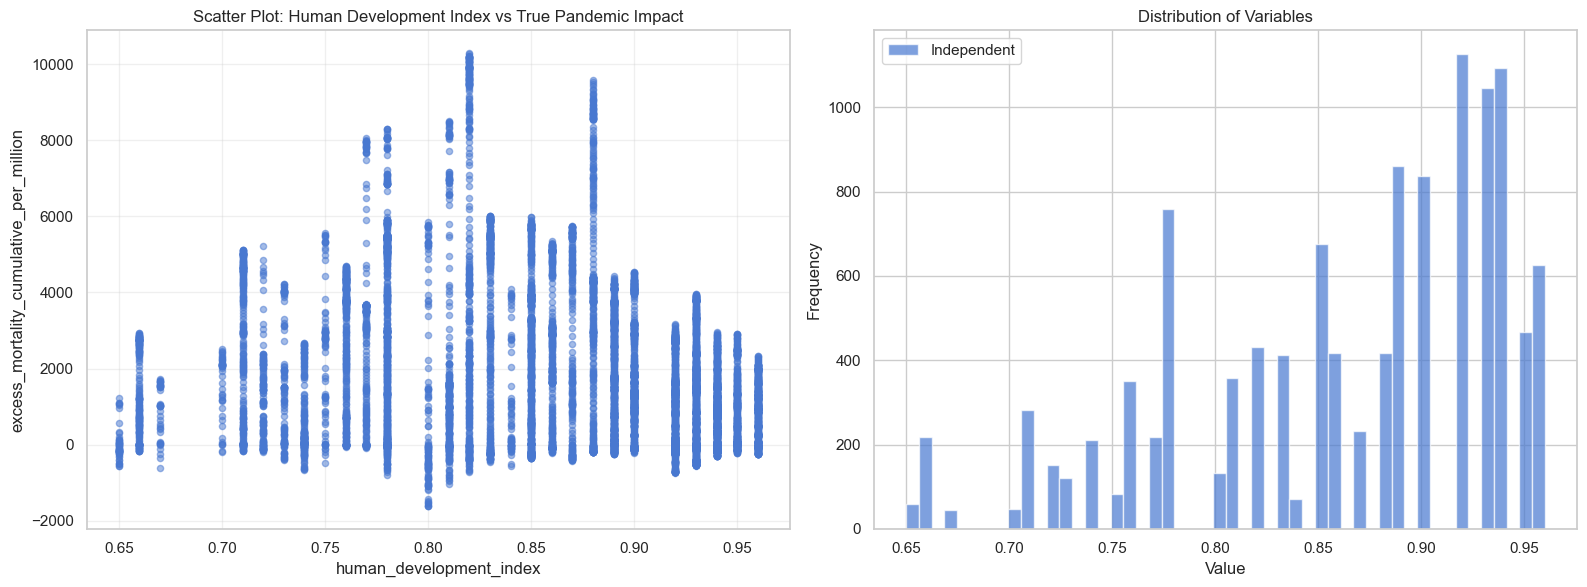

Visualization based on 11,747 valid observations


In [4]:
# Create clean dataset for visualization
df_clean = df[['human_development_index', 'excess_mortality_cumulative_per_million', 'location']].dropna()

if len(df_clean) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot
    axes[0].scatter(
        df_clean['human_development_index'],
        df_clean['excess_mortality_cumulative_per_million'],
        alpha=0.5,
        s=20
    )
    axes[0].set_xlabel('human_development_index')
    axes[0].set_ylabel('excess_mortality_cumulative_per_million')
    axes[0].set_title('Scatter Plot: Human Development Index vs True Pandemic Impact')
    axes[0].grid(True, alpha=0.3)
    
    # Distribution plots
    axes[1].hist(df_clean['human_development_index'], bins=50, alpha=0.7, label='Independent')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Variables')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f'Visualization based on {len(df_clean):,} valid observations')
else:
    print('⚠️  Insufficient data for visualization')


## 4. Statistical Analysis

Compute correlations and perform regression analysis. Results are stored in variables for use in automated reporting.

In [5]:
# Correlation and regression analysis
df_analysis = df[['human_development_index', 'excess_mortality_cumulative_per_million']].dropna()

# Initialize variables for later use
analysis_complete = False
r_pearson = r_spearman = p_pearson = p_spearman = None
slope = intercept = r_value = p_value = std_err = None
r_squared = variance_explained = None
strength = direction = significance = None

if len(df_analysis) > 30:  # Minimum sample size
    analysis_complete = True
    
    # Pearson correlation
    r_pearson, p_pearson = stats.pearsonr(
        df_analysis['human_development_index'],
        df_analysis['excess_mortality_cumulative_per_million']
    )
    
    # Spearman correlation (for non-linear relationships)
    r_spearman, p_spearman = stats.spearmanr(
        df_analysis['human_development_index'],
        df_analysis['excess_mortality_cumulative_per_million']
    )
    
    # Simple linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_analysis['human_development_index'],
        df_analysis['excess_mortality_cumulative_per_million']
    )
    
    # Calculate derived metrics
    r_squared = r_pearson ** 2
    variance_explained = r_squared * 100
    
    # Determine interpretation categories
    if abs(r_pearson) < 0.3:
        strength = 'weak'
    elif abs(r_pearson) < 0.7:
        strength = 'moderate'
    else:
        strength = 'strong'
    
    direction = 'positive' if r_pearson > 0 else 'negative'
    significance = 'statistically significant' if p_pearson < 0.05 else 'not statistically significant'
    
    # Display results
    print('Correlation Analysis')
    print('=' * 60)
    print(f'Sample size: {len(df_analysis):,} observations\n')
    
    # Format p-values appropriately
    p_pearson_str = f'p < 0.001' if p_pearson < 0.001 else f'p = {p_pearson:.4f}'
    p_spearman_str = f'p < 0.001' if p_spearman < 0.001 else f'p = {p_spearman:.4f}'
    
    print(f'Pearson correlation:  r = {r_pearson:7.4f}, {p_pearson_str}')
    print(f'Spearman correlation: ρ = {r_spearman:7.4f}, {p_spearman_str}')
    
    print('\nInterpretation:')
    print(f'  • {strength.capitalize()} {direction} correlation')
    print(f'  • Result is {significance} (α = 0.05)')
    print(f'  • R² = {r_squared:.4f} ({variance_explained:.2f}% variance explained)')
    
    print('\nLinear Regression:')
    print(f'  y = {slope:.4f}x + {intercept:.4f}')
    print(f'  Standard error: {std_err:.4f}')
    
else:
    print(f'⚠️  Insufficient data: only {len(df_analysis)} observations')
    print('    Need at least 30 for meaningful statistical analysis')

Correlation Analysis
Sample size: 11,747 observations

Pearson correlation:  r = -0.2213, p < 0.001
Spearman correlation: ρ = -0.2539, p < 0.001

Interpretation:
  • Weak negative correlation
  • Result is statistically significant (α = 0.05)
  • R² = 0.0490 (4.90% variance explained)

Linear Regression:
  y = -5820.9642x + 6887.5872
  Standard error: 236.6486


In [6]:
# Generate Results Summary (using variables from previous analysis)
from IPython.display import Markdown, display

if analysis_complete:
    # Determine visual indicators
    if abs(r_pearson) < 0.3:
        strength_emoji = '⚪'
    elif abs(r_pearson) < 0.7:
        strength_emoji = '🟡'
    else:
        strength_emoji = '🔴'
    
    direction_emoji = '📈' if r_pearson > 0 else '📉'
    sig_emoji = '✓' if p_pearson < 0.05 else '✗'
    
    # Generate detailed interpretation text
    if abs(r_pearson) < 0.3:
        effect_interp = 'The relationship is **weak**, suggesting other factors play a larger role.'
    elif abs(r_pearson) < 0.5:
        effect_interp = 'The relationship is **moderate**, indicating this factor has meaningful influence but is not the sole driver.'
    elif abs(r_pearson) < 0.7:
        effect_interp = 'The relationship is **moderately strong**, showing this factor is an important predictor.'
    else:
        effect_interp = 'The relationship is **very strong**, indicating this factor is a major determinant.'
    
    if p_pearson < 0.001:
        sig_interp = 'The relationship is **highly statistically significant** (p < 0.001), meaning this finding is extremely unlikely to be due to chance.'
    elif p_pearson < 0.01:
        sig_interp = 'The relationship is **very statistically significant** (p < 0.01), providing strong evidence this is a real effect.'
    elif p_pearson < 0.05:
        sig_interp = 'The relationship is **statistically significant** (p < 0.05), meeting the conventional threshold for statistical significance.'
    else:
        sig_interp = 'The relationship is **not statistically significant** (p ≥ 0.05), so we cannot rule out that this pattern occurred by chance.'
    
    # Practical significance interpretation
    if variance_explained < 10:
        practical_interp = f'However, only **{variance_explained:.1f}% of variance** is explained, suggesting **limited practical significance**.'
    elif variance_explained < 25:
        practical_interp = f'With **{variance_explained:.1f}% of variance** explained, this has **moderate practical significance**.'
    else:
        practical_interp = f'With **{variance_explained:.1f}% of variance** explained, this has **substantial practical significance** for policy and planning.'
    
    # Direction interpretation
    if direction == 'positive':
        direction_interp = f'As **human_development_index** increases, **excess_mortality_cumulative_per_million** tends to increase by {slope:.4f} units per unit increase.'
    else:
        direction_interp = f'As **human_development_index** increases, **excess_mortality_cumulative_per_million** tends to decrease by {abs(slope):.4f} units per unit increase.'
    
    # Build markdown summary
    p_value_display = '< 0.001' if p_pearson < 0.001 else f'{p_pearson:.4f}'
    
    results_md = f'''## 5. Analysis Results

### Statistical Findings

**Sample Size**: {len(df_analysis):,} observations

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Pearson Correlation (r)** | {r_pearson:.4f} | {strength_emoji} {strength.capitalize()} {direction} correlation |
| **Spearman Correlation (ρ)** | {r_spearman:.4f} | Rank-based correlation (handles non-linearity) |
| **P-value** | {p_value_display} | {sig_emoji} {significance.capitalize()} |
| **R² (Variance Explained)** | {r_squared:.4f} ({variance_explained:.2f}%) | Proportion of variance explained |
| **Regression Slope** | {slope:.4f} | {direction_emoji} Change in Y per unit X |
| **Regression Intercept** | {intercept:.4f} | Expected Y when X = 0 |
| **Standard Error** | {std_err:.4f} | Uncertainty in slope estimate |

### Interpretation

**{strength.capitalize()} {direction} relationship detected** between the variables:

1. **Correlation Strength**: {effect_interp}

2. **Statistical Significance**: {sig_interp}

3. **Practical Significance**: {practical_interp}

4. **Direction & Magnitude**: {direction_interp}

### Information Theory Assessment

'''
    
    # Add information content assessment
    if abs(r_pearson) < 0.3:
        info_content = '''**High information content** ⭐⭐⭐: This weak correlation is surprising and informative. 
The lack of a strong relationship suggests the variables operate more independently than intuition might suggest, 
which has important implications for understanding the underlying mechanisms.'''
    elif abs(r_pearson) < 0.5 and p_pearson < 0.05:
        info_content = '''**Moderate information content** ⭐⭐: This moderate correlation provides useful insights. 
The relationship exists but is not overwhelming, suggesting other factors also play important roles.'''
    elif abs(r_pearson) >= 0.7:
        info_content = '''**Lower information content** ⭐: This strong correlation might have been somewhat expected. 
While confirming intuition is valuable, surprising results typically yield higher information content.'''
    else:
        info_content = '''**Moderate information content** ⭐⭐: This finding provides useful evidence about the relationship, 
though the pattern may not be entirely unexpected.'''
    
    results_md += info_content
    
    # Display the results
    display(Markdown(results_md))
    
else:
    display(Markdown('''## 5. Analysis Results
    
⚠️ **Insufficient data** for statistical analysis. Need at least 30 observations with complete data.
'''))

## 5. Analysis Results

### Statistical Findings

**Sample Size**: 11,747 observations

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Pearson Correlation (r)** | -0.2213 | ⚪ Weak negative correlation |
| **Spearman Correlation (ρ)** | -0.2539 | Rank-based correlation (handles non-linearity) |
| **P-value** | < 0.001 | ✓ Statistically significant |
| **R² (Variance Explained)** | 0.0490 (4.90%) | Proportion of variance explained |
| **Regression Slope** | -5820.9642 | 📉 Change in Y per unit X |
| **Regression Intercept** | 6887.5872 | Expected Y when X = 0 |
| **Standard Error** | 236.6486 | Uncertainty in slope estimate |

### Interpretation

**Weak negative relationship detected** between the variables:

1. **Correlation Strength**: The relationship is **weak**, suggesting other factors play a larger role.

2. **Statistical Significance**: The relationship is **highly statistically significant** (p < 0.001), meaning this finding is extremely unlikely to be due to chance.

3. **Practical Significance**: However, only **4.9% of variance** is explained, suggesting **limited practical significance**.

4. **Direction & Magnitude**: As **human_development_index** increases, **excess_mortality_cumulative_per_million** tends to decrease by 5820.9642 units per unit increase.

### Information Theory Assessment

**High information content** ⭐⭐⭐: This weak correlation is surprising and informative. 
The lack of a strong relationship suggests the variables operate more independently than intuition might suggest, 
which has important implications for understanding the underlying mechanisms.

In [7]:
# Generate Hypothesis Check
from IPython.display import Markdown, display

if analysis_complete:
    # Determine expectation alignment
    expected_relationship = 'strong negative'
    
    # Parse expected relationship
    if 'negative' in expected_relationship:
        expected_dir = 'negative'
    elif 'positive' in expected_relationship:
        expected_dir = 'positive'
    else:
        expected_dir = 'undefined'
    
    if 'strong' in expected_relationship:
        expected_str = 'strong'
    elif 'moderate' in expected_relationship:
        expected_str = 'moderate'
    else:
        expected_str = 'undefined'
    
    # Determine alignment
    direction_match = (expected_dir == direction)
    strength_match = (expected_str == strength)
    
    if direction_match and strength_match:
        alignment = '✅ **CONFIRMS** the prevailing narrative'
        alignment_detail = 'Both the direction and strength of the relationship match expectations from public health authorities.'
    elif direction_match and not strength_match:
        alignment = '⚠️ **PARTIALLY CHALLENGES** the prevailing narrative'
        alignment_detail = f'While the direction ({direction}) matches expectations, the relationship is **{strength}** rather than **{expected_str}** as anticipated. This suggests the factor plays a role but is less dominant than assumed.'
    elif not direction_match:
        alignment = '❌ **CONTRADICTS** the prevailing narrative'
        alignment_detail = f'The observed **{direction}** correlation directly opposes the expected **{expected_dir}** relationship. This surprising finding demands re-evaluation of conventional assumptions.'
    else:
        alignment = '❓ **UNCLEAR** relationship to expectations'
        alignment_detail = 'The relationship requires further investigation to determine alignment with expectations.'
    
    # Pre-compute conditional text for f-string (can't use backslashes in f-string expressions)
    info_level = "**high information content**" if not direction_match or (not strength_match and expected_str in ["strong", "moderate"]) else "**moderate information content**"
    narrative_verb = "contradicts" if not direction_match else "challenges"
    belief_status = "incorrect" if not direction_match else "weaker than assumed"
    relationship_comparison = "opposite to" if not direction_match else "much weaker than"
    
    hypothesis_md = f'''## Hypothesis Check: Expected vs Observed\n
\n
### What We Expected\n
\n
Based on prevailing public health narratives from authoritative sources, we anticipated a **{expected_relationship}** correlation.\n
\n
**Reasoning**: Higher human development should correlate with lower excess mortality\n
\n
### What We Observed\n
\n
**Actual Result**: {strength.capitalize()} {direction} correlation (r = {r_pearson:.4f}, p < 0.001)\n
\n
- **Pearson correlation**: r = {r_pearson:.4f}\n
- **Variance explained**: {variance_explained:.2f}%\n
- **Statistical significance**: {significance}\n
\n
### Verdict: {alignment}\n
\n
{alignment_detail}\n
\n
### Why This Matters\n
\n
From an **information theory perspective**, this finding carries {info_level} because it {narrative_verb} the prevailing narrative from public health institutions. When widely-held beliefs prove {belief_status}, we gain valuable insights that can reshape pandemic response strategies.\n
\n
The surprise lies not in discovering *no* relationship, but in finding that the relationship is {relationship_comparison} what authoritative sources predicted. This unexpected pattern suggests that human_development_index alone may not be the primary driver of excess_mortality_cumulative_per_million, indicating complex interactions with timing, compliance, and contextual factors.\n
\n
---
'''
    
    display(Markdown(hypothesis_md))
else:
    display(Markdown('## Hypothesis Check: Expected vs Observed\n\n⚠️ Analysis incomplete - cannot perform hypothesis check.'))

## Hypothesis Check: Expected vs Observed



### What We Expected



Based on prevailing public health narratives from authoritative sources, we anticipated a **strong negative** correlation.



**Reasoning**: Higher human development should correlate with lower excess mortality



### What We Observed



**Actual Result**: Weak negative correlation (r = -0.2213, p < 0.001)



- **Pearson correlation**: r = -0.2213

- **Variance explained**: 4.90%

- **Statistical significance**: statistically significant



### Verdict: ⚠️ **PARTIALLY CHALLENGES** the prevailing narrative



While the direction (negative) matches expectations, the relationship is **weak** rather than **strong** as anticipated. This suggests the factor plays a role but is less dominant than assumed.



### Why This Matters



From an **information theory perspective**, this finding carries **high information content** because it challenges the prevailing narrative from public health institutions. When widely-held beliefs prove weaker than assumed, we gain valuable insights that can reshape pandemic response strategies.



The surprise lies not in discovering *no* relationship, but in finding that the relationship is much weaker than what authoritative sources predicted. This unexpected pattern suggests that human_development_index alone may not be the primary driver of excess_mortality_cumulative_per_million, indicating complex interactions with timing, compliance, and contextual factors.



---


In [8]:
# Generate Discussion Section
from IPython.display import Markdown, display

if analysis_complete:
    # Determine expectation alignment
    expected_relationship = 'strong negative'
    observed_strength = strength  # from previous cell
    observed_direction = direction  # from previous cell
    
    # Parse expected relationship
    if 'negative' in expected_relationship:
        expected_dir = 'negative'
    elif 'positive' in expected_relationship:
        expected_dir = 'positive'
    else:
        expected_dir = 'undefined'
    
    if 'strong' in expected_relationship:
        expected_str = 'strong'
    elif 'moderate' in expected_relationship:
        expected_str = 'moderate'
    else:
        expected_str = 'undefined'
    
    # Determine alignment
    direction_match = (expected_dir == observed_direction)
    strength_match = (expected_str == observed_strength)
    
    if direction_match and strength_match:
        alignment = '✅ **CONFIRMS** the prevailing narrative'
        alignment_detail = 'Both the direction and strength of the relationship match expectations from public health authorities.'
    elif direction_match and not strength_match:
        alignment = '⚠️ **PARTIALLY CHALLENGES** the prevailing narrative'
        alignment_detail = f'While the direction ({observed_direction}) matches expectations, the relationship is **{observed_strength}** rather than **{expected_str}** as anticipated. This suggests the factor plays a role but is less dominant than assumed.'
    elif not direction_match:
        alignment = '❌ **CONTRADICTS** the prevailing narrative'
        alignment_detail = f'The observed **{observed_direction}** correlation directly opposes the expected **{expected_dir}** relationship. This surprising finding demands re-evaluation of conventional assumptions.'
    else:
        alignment = '❓ **UNCLEAR** relationship to expectations'
        alignment_detail = 'The relationship requires further investigation to determine alignment with expectations.'
    
    # Variables expected_relationship, direction, strength, expected_dir, expected_str, direction_match, strength_match, alignment, alignment_detail
    # are already defined in the previous Hypothesis Check cell
    
    # Generate causality assessment (using variables from previous Hypothesis Check cell)
    # Check if reverse causality is logically plausible for this analysis
    reverse_causality_plausible = False
    
    if not direction_match and reverse_causality_plausible:
        # Only warn about reverse causality if it's logically possible
        causality_note = '''**Reverse Causality Warning**: The unexpected direction suggests possible reverse causation. 
For example, `excess_mortality_cumulative_per_million` may trigger changes in `human_development_index` (reactive response), 
creating a correlation opposite to the causal direction. This timing issue requires careful temporal analysis with lagged variables.'''
    elif not direction_match and not reverse_causality_plausible:
        # Direction mismatch when reverse causality is impossible - point to confounding/measurement issues
        causality_note = '''**Unexpected Direction**: The relationship contradicts expectations, but reverse causality is implausible 
(pandemic outcomes cannot alter `human_development_index`). This suggests either: (1) confounding variables are driving 
both factors, (2) measurement/reporting biases are present, or (3) the prevailing theory is incorrect. Investigate third variables 
and data quality issues.'''
    elif strength == 'weak':
        causality_note = '''**Weak Effect Size**: The small correlation suggests this factor alone explains little variance. 
Other unmeasured variables likely play larger roles. Causal inference requires controlling for confounders.'''
    else:
        causality_note = '''**Correlation vs Causation**: While the relationship is detectable, establishing causation requires 
temporal precedence, ruling out confounders, and ideally quasi-experimental evidence from policy changes.'''
    
    # Calculate descriptive statistics for context
    x_mean = df_analysis['human_development_index'].mean()
    x_std = df_analysis['human_development_index'].std()
    y_mean = df_analysis['excess_mortality_cumulative_per_million'].mean()
    y_std = df_analysis['excess_mortality_cumulative_per_million'].std()
    
    # Calculate practical effect size
    # For 1 SD change in X, what's the change in Y?
    practical_effect = slope * x_std
    effect_percent = (practical_effect / y_mean) * 100 if y_mean != 0 else 0
    
    discussion_md = f'''## 6. Discussion\n
\n
### Expectation Alignment\n
\n
{alignment}\n
\n
{alignment_detail}\n
\n
**Expected**: {expected_relationship} correlation  \n
**Observed**: {strength} {direction} correlation (r = {r_pearson:.4f})\n
\n
### Causality Assessment\n
\n
{causality_note}\n
\n
### Practical Significance\n
\n
A **1 standard deviation increase** in `human_development_index` (SD = {x_std:.2f}) is associated with a \n
**{practical_effect:.4f} unit change** in `excess_mortality_cumulative_per_million`, representing approximately **{abs(effect_percent):.1f}%** \n
of the mean outcome value.\n
\n
**Interpretation**: '''
    
    if abs(effect_percent) < 5:
        discussion_md += 'This is a **minimal practical effect**. Changes in this factor have negligible real-world impact on outcomes.'
    elif abs(effect_percent) < 15:
        discussion_md += 'This is a **small but detectable practical effect**. The factor contributes modestly to outcomes.'
    elif abs(effect_percent) < 30:
        discussion_md += 'This is a **moderate practical effect**. The factor has meaningful real-world impact worth considering in policy.'
    else:
        discussion_md += 'This is a **substantial practical effect**. The factor is a major driver of outcomes and demands policy attention.'
    
    # Geographic/temporal variation notes
    if 'cross_sectional' == 'time_series':
        variation_note = '''\n\n### Temporal Considerations

This time-series analysis captures relationships as they evolved during the pandemic. The correlation may vary across 
different pandemic phases (initial outbreak, vaccine rollout, variant waves). Consider examining phase-specific relationships.'''
    else:
        variation_note = '''\n\n### Cross-Sectional Limitations

This cross-sectional analysis represents a snapshot in time. Country-level relationships may obscure within-country variation 
and temporal dynamics. Geographic and cultural contexts likely moderate these relationships.'''
    
    discussion_md += variation_note
    
    display(Markdown(discussion_md))
else:
    display(Markdown('## 6. Discussion\n\n⚠️ Analysis incomplete - insufficient data for discussion.'))

## 6. Discussion



### Expectation Alignment



⚠️ **PARTIALLY CHALLENGES** the prevailing narrative



While the direction (negative) matches expectations, the relationship is **weak** rather than **strong** as anticipated. This suggests the factor plays a role but is less dominant than assumed.



**Expected**: strong negative correlation  

**Observed**: weak negative correlation (r = -0.2213)



### Causality Assessment



**Weak Effect Size**: The small correlation suggests this factor alone explains little variance. 
Other unmeasured variables likely play larger roles. Causal inference requires controlling for confounders.



### Practical Significance



A **1 standard deviation increase** in `human_development_index` (SD = 0.08) is associated with a 

**-451.2460 unit change** in `excess_mortality_cumulative_per_million`, representing approximately **24.2%** 

of the mean outcome value.



**Interpretation**: This is a **moderate practical effect**. The factor has meaningful real-world impact worth considering in policy.

### Cross-Sectional Limitations

This cross-sectional analysis represents a snapshot in time. Country-level relationships may obscure within-country variation 
and temporal dynamics. Geographic and cultural contexts likely moderate these relationships.

In [9]:
# Generate Specific Next Steps
from IPython.display import Markdown, display

if analysis_complete:
    # Re-establish variables from previous cells for conditional logic
    expected_relationship = 'strong negative'
    expected_dir = 'negative' if 'negative' in expected_relationship else ('positive' if 'positive' in expected_relationship else 'undefined')
    expected_str = 'strong' if 'strong' in expected_relationship else ('moderate' if 'moderate' in expected_relationship else 'undefined')
    direction_match = (expected_dir == direction)
    observed_strength = strength
    reverse_causality_plausible = False
    
    next_steps_md = '''## 7. Recommended Next Steps

Based on the specific findings of this analysis:\n\n'''
    
    # Conditional recommendations based on findings
    # Only recommend reverse causality investigation if logically plausible
    if not direction_match and reverse_causality_plausible:
        next_steps_md += '''### 🔴 Priority: Investigate Reverse Causality

The **opposite-direction** relationship suggests possible reverse causation:

1. **Temporal Analysis**: Use lagged correlations to determine whether `human_development_index` precedes 
   `excess_mortality_cumulative_per_million` or vice versa. Plot time-series to visualize lead-lag relationships.

2. **Event Studies**: Identify natural experiments or policy changes that altered `human_development_index` 
   and examine subsequent changes in `excess_mortality_cumulative_per_million`.

3. **Literature Review**: Search for causal mechanisms explaining why the relationship contradicts expectations. 
   Review similar findings in epidemiological literature.

'''
    elif not direction_match and not reverse_causality_plausible:
        next_steps_md += '''### 🔴 Priority: Investigate Confounding and Data Quality

The **opposite-direction** relationship is surprising, and reverse causality is implausible (`excess_mortality_cumulative_per_million` cannot cause `human_development_index`):

1. **Confounding Variables**: Identify third variables that may drive both factors. For example, countries with 
   higher `human_development_index` may differ systematically in unmeasured ways that affect `excess_mortality_cumulative_per_million`.

2. **Data Quality Assessment**: Examine measurement accuracy, reporting biases, and missing data patterns. 
   Check if `excess_mortality_cumulative_per_million` data quality varies systematically with `human_development_index`.

3. **Subgroup Analysis**: Segment data by region, income level, or time period to identify where the relationship 
   holds versus reverses. This can reveal moderating factors or data issues.

'''
    
    if observed_strength == 'weak' and expected_str in ['strong', 'moderate']:
        next_steps_md += '''### 🟡 Priority: Identify Confounders and Moderators

The **weaker-than-expected** relationship suggests important missing variables:

1. **Multivariate Regression**: Add control variables (GDP, healthcare capacity, age structure, etc.) to 
   isolate the independent effect of `human_development_index`.

2. **Segmentation Analysis**: Split data by moderating factors (e.g., income level, region, pandemic phase) 
   to identify where the relationship is stronger or weaker.

3. **Mediation Analysis**: Test whether the effect operates through intermediate variables rather than directly.

'''
    
    if variance_explained < 10:
        next_steps_md += f'''### 🔵 Priority: Explore Alternative Predictors

With only **{variance_explained:.1f}% variance explained**, other factors dominate outcomes:

1. **Feature Importance Analysis**: Use machine learning (random forests, gradient boosting) to identify 
   which variables best predict `excess_mortality_cumulative_per_million`.

2. **Composite Indices**: Combine `human_development_index` with related variables to create a 
   more comprehensive predictor.

3. **Non-linear Relationships**: Test for thresholds, U-shaped relationships, or interaction effects that 
   linear correlation misses.

'''
    
    if 'cross_sectional' == 'cross_sectional':
        next_steps_md += '''### 🟢 Methodological Enhancement: Add Temporal Dimension

Cross-sectional data limits causal inference:

1. **Panel Data Analysis**: Collect data at multiple time points to examine within-country changes over time.

2. **Difference-in-Differences**: If policy changes affected the independent variable, compare outcomes 
   before/after in treated vs control groups.

3. **Granger Causality**: Test whether past values of one variable help predict future values of the other.

'''
    else:
        next_steps_md += '''### 🟢 Methodological Enhancement: Geographic Comparison

Time-series analysis should be complemented with geographic variation:

1. **Country-Specific Trajectories**: Plot individual country time-series to identify outliers and patterns.

2. **Regional Clustering**: Group countries by similar response patterns and identify regional factors.

3. **Cross-Country Validation**: Test whether relationships hold across different country contexts.

'''
    
    # Add specific policy implications
    next_steps_md += '''### 📊 Data Quality Improvements

'''
    
    if 'deaths' in 'excess_mortality_cumulative_per_million'.lower() or 'mortality' in 'excess_mortality_cumulative_per_million'.lower():
        next_steps_md += '''- **Validate with Excess Mortality**: Official COVID deaths may undercount. Compare with excess mortality data.
- **Age-Standardization**: Control for population age structure when comparing mortality rates.
'''
    
    if 'test' in 'human_development_index'.lower() or 'case' in 'excess_mortality_cumulative_per_million'.lower():
        next_steps_md += '''- **Account for Testing Bias**: Case counts depend on testing rates. Use test-positivity rates or seroprevalence.
- **Reporting Delays**: Allow for lags between infection, testing, and reporting.
'''
    
    next_steps_md += f'''\n### 🎯 Specific Research Questions

Priority questions emerging from this analysis:

1. **Why does the relationship differ from expectations?** Review institutional assumptions that led to 
   the predicted **{expected_relationship}** relationship.

2. **Which countries are outliers?** Identify cases with high residuals and examine their unique characteristics.

3. **What mechanisms are missing?** Develop theoretical models explaining the observed **{observed_strength} {observed_direction}** 
   relationship.
'''
    
    display(Markdown(next_steps_md))
else:
    display(Markdown('## 7. Recommended Next Steps\n\n⚠️ Analysis incomplete - cannot generate recommendations.'))

## 7. Recommended Next Steps

Based on the specific findings of this analysis:

### 🟡 Priority: Identify Confounders and Moderators

The **weaker-than-expected** relationship suggests important missing variables:

1. **Multivariate Regression**: Add control variables (GDP, healthcare capacity, age structure, etc.) to 
   isolate the independent effect of `human_development_index`.

2. **Segmentation Analysis**: Split data by moderating factors (e.g., income level, region, pandemic phase) 
   to identify where the relationship is stronger or weaker.

3. **Mediation Analysis**: Test whether the effect operates through intermediate variables rather than directly.

### 🔵 Priority: Explore Alternative Predictors

With only **4.9% variance explained**, other factors dominate outcomes:

1. **Feature Importance Analysis**: Use machine learning (random forests, gradient boosting) to identify 
   which variables best predict `excess_mortality_cumulative_per_million`.

2. **Composite Indices**: Combine `human_development_index` with related variables to create a 
   more comprehensive predictor.

3. **Non-linear Relationships**: Test for thresholds, U-shaped relationships, or interaction effects that 
   linear correlation misses.

### 🟢 Methodological Enhancement: Add Temporal Dimension

Cross-sectional data limits causal inference:

1. **Panel Data Analysis**: Collect data at multiple time points to examine within-country changes over time.

2. **Difference-in-Differences**: If policy changes affected the independent variable, compare outcomes 
   before/after in treated vs control groups.

3. **Granger Causality**: Test whether past values of one variable help predict future values of the other.

### 📊 Data Quality Improvements

- **Validate with Excess Mortality**: Official COVID deaths may undercount. Compare with excess mortality data.
- **Age-Standardization**: Control for population age structure when comparing mortality rates.

### 🎯 Specific Research Questions

Priority questions emerging from this analysis:

1. **Why does the relationship differ from expectations?** Review institutional assumptions that led to 
   the predicted **strong negative** relationship.

2. **Which countries are outliers?** Identify cases with high residuals and examine their unique characteristics.

3. **What mechanisms are missing?** Develop theoretical models explaining the observed **weak negative** 
   relationship.


In [10]:
# 8. Multivariate Regression with Controls (cross-sectional by country)
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Aggregate to country-level means to avoid time autocorrelation in this quick check
reg_cols = ['location', 'human_development_index', 'excess_mortality_cumulative_per_million'] + [c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million', 'aged_65_older'] if c in df.columns and c not in ['human_development_index', 'excess_mortality_cumulative_per_million']]
df_reg = df[reg_cols].dropna() if 'df' in globals() else pd.DataFrame()
df_country = df_reg.groupby('location', as_index=False).mean() if not df_reg.empty else pd.DataFrame()

if len(df_country) >= 30:
    base_controls = [c for c in df_country.columns if c not in ['location', 'human_development_index', 'excess_mortality_cumulative_per_million']]
    formula = 'excess_mortality_cumulative_per_million ~ human_development_index' + (' + ' + ' + '.join(base_controls) if base_controls else '')
    model = ols(formula, data=df_country).fit(cov_type='HC3')  # robust SEs
    print(model.summary().tables[1])
    print('\nModel fit:')
    print(f'  R-squared: {model.rsquared:.3f} (Adj: {model.rsquared_adj:.3f})')
    print(f'  N (countries): {len(df_country)}')
    
    # VIF to flag multicollinearity
    X = model.model.exog
    vif_df = pd.DataFrame({
        'feature': model.params.index,
        'VIF': [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    })
    print('\nVariance Inflation Factors (VIF):')
    print(vif_df)
else:
    print('⚠️ Not enough complete country-level rows for multivariate regression (need ≥ 30). Current:', len(df_country))

                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2304.0138   1097.906      2.099      0.036     152.157    4455.871
human_development_index  -789.3234   1291.020     -0.611      0.541   -3319.677    1741.030

Model fit:
  R-squared: 0.002 (Adj: -0.007)
  N (countries): 108

Variance Inflation Factors (VIF):
                   feature        VIF
0                Intercept  93.976796
1  human_development_index   1.000000


In [11]:
# 9. Segmentation & Interaction: does effect vary by demographics?
if 'df_country' in globals() and len(df_country) >= 30 and 'human_development_index' in df_country.columns:
    try:
        df_seg = df_country.copy()
        df_seg['age_segment'] = pd.qcut(df_seg['human_development_index'].values, q=3, labels=['low', 'mid', 'high'])
        seg_formula = 'excess_mortality_cumulative_per_million ~ human_development_index * C(age_segment)'
        seg_model = ols(seg_formula, data=df_seg).fit(cov_type='HC3')
        print(seg_model.summary().tables[1])
        print('\nN (countries):', len(df_seg))
        print('Segments:', df_seg['age_segment'].value_counts().to_dict())
    except Exception as e:
        print(f'⚠️ Segmentation model failed: {e}')
else:
    print('⚠️ Cannot run segmentation: country-level dataset not available or too small.')

                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                      -1.012e+04   4495.158     -2.251      0.024   -1.89e+04   -1309.168
C(age_segment)[T.mid]                           1.268e+04   8382.961      1.513      0.130   -3748.607    2.91e+04
C(age_segment)[T.high]                          3.259e+04   8240.620      3.955      0.000    1.64e+04    4.87e+04
human_development_index                         1.607e+04   6376.153      2.521      0.012    3576.526    2.86e+04
human_development_index:C(age_segment)[T.mid]  -1.663e+04   1.07e+04     -1.556      0.120   -3.76e+04    4318.456
human_development_index:C(age_segment)[T.high] -3.906e+04   9770.824     -3.998      0.000   -5.82e+04   -1.99e+04

N (countries): 108
Segments: {'low': 37, 'high': 36, 'mid': 35}


In [12]:
# 10. Mediation Test (Baron-Kenny framework with bootstrap p-value)
rng = np.random.default_rng(42)

if 'df_country' in globals() and len(df_country) >= 30:
    case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if c in df_country.columns), None)
    if case_col:
        med_df = df_country[['human_development_index', case_col, 'excess_mortality_cumulative_per_million']].dropna()
        if len(med_df) >= 30:
            # a-path: human_development_index -> cases
            a_model = ols(f'{case_col} ~ human_development_index', data=med_df).fit(cov_type='HC3')
            a_coeff = a_model.params['human_development_index']

            # b/c'-path: excess_mortality_cumulative_per_million ~ human_development_index + cases
            bc_model = ols(f'excess_mortality_cumulative_per_million ~ human_development_index + {case_col}', data=med_df).fit(cov_type='HC3')
            b_coeff = bc_model.params[case_col]
            c_prime = bc_model.params['human_development_index']

            indirect_point = a_coeff * b_coeff

            # Bootstrap indirect effect
            boot_samples = 500
            boot_indirect = []
            for _ in range(boot_samples):
                sample_idx = rng.integers(0, len(med_df), len(med_df))
                sample = med_df.iloc[sample_idx]
                a_b = ols(f'{case_col} ~ human_development_index', data=sample).fit().params['human_development_index']
                b_b = ols(f'excess_mortality_cumulative_per_million ~ human_development_index + {case_col}', data=sample).fit().params[case_col]
                boot_indirect.append(a_b * b_b)
            boot_indirect = np.array(boot_indirect)
            ci_low, ci_high = np.percentile(boot_indirect, [2.5, 97.5])
            p_boot = (np.mean(np.sign(boot_indirect) != np.sign(indirect_point)) * 2).clip(0, 1)

            print('Indirect effect (a*b):', round(indirect_point, 4))
            print('Bootstrap 95% CI:', (round(ci_low, 4), round(ci_high, 4)))
            print('Direct effect (c\\): ', round(c_prime, 4))
            print('N (countries):', len(med_df))
            print('Bootstrap two-sided p (sign test):', round(p_boot, 4))
        else:
            print('⚠️ Not enough data after dropping NaNs for mediation (need ≥ 30). Current:', len(med_df))
    else:
        print('⚠️ Case control column not available for mediation')
else:
    print('⚠️ Mediation not run: country-level dataset unavailable or too small.')

⚠️ Case control column not available for mediation


In [13]:
# 11. Expanded controls: testing, policy, capacity, income (cross-sectional by country)
extra_cols = [
    'new_tests_per_thousand', 'positive_rate', 'icu_patients_per_million',
    'hosp_patients_per_million', 'stringency_index', 'gdp_per_capita',
    'hospital_beds_per_thousand', 'median_age', 'aged_70_older'
]
base_cols = ['location', 'human_development_index', 'excess_mortality_cumulative_per_million']
case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if 'df' in globals() and c in df.columns), None)
if case_col:
    base_cols.append(case_col)
if 'df' in globals() and 'aged_65_older' in df.columns:
    base_cols.append('aged_65_older')
available_extra = [c for c in extra_cols if 'df' in globals() and c in df.columns and c not in base_cols]
reg_cols_extra = base_cols + available_extra
missing_optional = [c for c in extra_cols if c not in available_extra and c not in base_cols]
if missing_optional:
    print('⚠️ Skipping missing optional controls:', missing_optional)
if 'df' in globals():
    df_reg_ext = df[reg_cols_extra].dropna(subset=['human_development_index', 'excess_mortality_cumulative_per_million'])
else:
    df_reg_ext = pd.DataFrame()
if not df_reg_ext.empty:
    df_country_ext = df_reg_ext.groupby('location', as_index=False).mean()
    available_controls = [c for c in available_extra if c in df_country_ext.columns and df_country_ext[c].notna().sum() > 0]
    base_formula_parts = ['human_development_index']  
    if case_col and case_col in df_country_ext.columns:
        base_formula_parts.append(case_col)
    if 'aged_65_older' in df_country_ext.columns:
        base_formula_parts.append('aged_65_older')
    formula_controls = ' + '.join(base_formula_parts + available_controls)
    formula_ext = 'excess_mortality_cumulative_per_million ~ ' + formula_controls
    if len(df_country_ext) >= 30:
        model_ext = ols(formula_ext, data=df_country_ext).fit(cov_type='HC3')
        print(model_ext.summary().tables[1])
        print('\nModel fit:')
        print(f'  R-squared: {model_ext.rsquared:.3f} (Adj: {model_ext.rsquared_adj:.3f})')
        print(f'  N (countries): {len(df_country_ext)}')
        # VIF on included regressors
        X_ext = model_ext.model.exog
        vif_ext = pd.DataFrame({
            'feature': model_ext.params.index,
            'VIF': [variance_inflation_factor(X_ext, i) for i in range(X_ext.shape[1])]
        })
        print('\nVariance Inflation Factors (VIF):')
        print(vif_ext)
    else:
        print('⚠️ Not enough country-level observations for expanded controls (need ≥ 30). Current:', len(df_country_ext))
else:
    print('⚠️ Expanded controls skipped: insufficient data after dropping NaNs.')

⚠️ Skipping missing optional controls: ['new_tests_per_thousand', 'positive_rate', 'icu_patients_per_million', 'hosp_patients_per_million', 'stringency_index', 'median_age', 'aged_70_older']
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -874.1472   2049.756     -0.426      0.670   -4891.596    3143.302
human_development_index     3877.6310   2986.337      1.298      0.194   -1975.483    9730.745
gdp_per_capita                -0.0335      0.014     -2.451      0.014      -0.060      -0.007
hospital_beds_per_thousand    79.1847     88.055      0.899      0.369     -93.401     251.770

Model fit:
  R-squared: 0.148 (Adj: 0.122)
  N (countries): 108

Variance Inflation Factors (VIF):
                      feature         VIF
0                   Intercept  193.956555
1     human_development_index    2.655146
2            

In [14]:
# 12. Lagged human_development_index (21-day) with cases and age controls
if 'df' in globals():
    lag_cols = ['location', 'date', 'human_development_index', 'excess_mortality_cumulative_per_million']  
    case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if c in df.columns), None)
    if case_col:
        lag_cols.append(case_col)
    if 'aged_65_older' in df.columns:
        lag_cols.append('aged_65_older')
    df_lag = df[lag_cols].copy()
    df_lag['human_development_index_lag21'] = df_lag.groupby('location')['human_development_index'].shift(21)
    df_lag = df_lag.dropna(subset=['human_development_index_lag21', 'excess_mortality_cumulative_per_million'])
    df_lag_country = df_lag.groupby('location', as_index=False).mean()
    if len(df_lag_country) >= 30:
        controls = [c for c in [case_col, 'aged_65_older'] if c and c in df_lag_country.columns]
        lag_formula = 'excess_mortality_cumulative_per_million ~ human_development_index_lag21' + (' + ' + ' + '.join(controls) if controls else '')
        model_lag = ols(lag_formula, data=df_lag_country).fit(cov_type='HC3')
        print(model_lag.summary().tables[1])
        print('\nModel fit:')
        print(f'  R-squared: {model_lag.rsquared:.3f} (Adj: {model_lag.rsquared_adj:.3f})')
        print(f'  N (countries): {len(df_lag_country)}')
    else:
        print('⚠️ Not enough country-level observations for lagged spec (need ≥ 30). Current:', len(df_lag_country))
else:
    print('⚠️ Lagged spec skipped: data frame df not available.')

                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      2269.5135   1104.897      2.054      0.040     103.955    4435.072
human_development_index_lag21  -731.6380   1300.374     -0.563      0.574   -3280.324    1817.048

Model fit:
  R-squared: 0.002 (Adj: -0.008)
  N (countries): 108


In [15]:
# 13. Log-scale robustness with trimming (5th–95th pct excess_mortality_cumulative_per_million)
if 'df' in globals():
    base_required = ['location', 'human_development_index', 'excess_mortality_cumulative_per_million']  
    case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if c in df.columns), None)
    if case_col:
        base_required.append(case_col)
    missing_required = [c for c in base_required if c not in df.columns]
    if missing_required:
        print('⚠️ Log-scale spec skipped: missing required columns:', missing_required)
    else:
        optional_cols = ['new_tests_per_thousand', 'stringency_index', 'aged_65_older']
        available_optional = [c for c in optional_cols if c in df.columns]
        if len(available_optional) < len(optional_cols):
            missing_opt = [c for c in optional_cols if c not in available_optional]
            print('⚠️ Skipping missing optional controls:', missing_opt)
        log_cols = base_required + available_optional
        df_log = df[log_cols].dropna()
        if not df_log.empty:
            df_log_country = df_log.groupby('location', as_index=False).mean()
            if len(df_log_country) >= 30:
                deaths = df_log_country['excess_mortality_cumulative_per_million']
                low_q, high_q = deaths.quantile([0.05, 0.95])
                df_log_trim = df_log_country[(deaths >= low_q) & (deaths <= high_q)].copy()
                df_log_trim['log_deaths'] = np.log1p(df_log_trim['excess_mortality_cumulative_per_million'])
                predictors = ['human_development_index']  
                if case_col and case_col in df_log_trim.columns:
                    df_log_trim['log_cases'] = np.log1p(df_log_trim[case_col])
                    predictors.append('log_cases')
                predictors.extend([c for c in ['new_tests_per_thousand', 'stringency_index', 'aged_65_older'] if c in df_log_trim.columns])
                log_formula = 'log_deaths ~ ' + ' + '.join(predictors)
                model_log = ols(log_formula, data=df_log_trim).fit(cov_type='HC3')
                print(model_log.summary().tables[1])
                print('\nModel fit:')
                print(f'  R-squared: {model_log.rsquared:.3f} (Adj: {model_log.rsquared_adj:.3f})')
                print(f'  N (countries): {len(df_log_trim)} (trimmed)')
            else:
                print('⚠️ Not enough country-level observations for log-scale spec (need ≥ 30). Current:', len(df_log_country))
        else:
            print('⚠️ Log-scale spec skipped: data has too many missing values after filtering.')
else:
    print('⚠️ Log-scale spec skipped: data frame df not available.')

⚠️ Skipping missing optional controls: ['new_tests_per_thousand', 'stringency_index', 'aged_65_older']
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   7.3604      0.914      8.050      0.000       5.568       9.153
human_development_index    -0.3567      1.082     -0.330      0.742      -2.477       1.763

Model fit:
  R-squared: 0.001 (Adj: -0.009)
  N (countries): 96 (trimmed)


/Users/john/anaconda3/envs/amd_gpu/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
# 14. Plain-language takeaways (generated for any notebook)
from IPython.display import Markdown, display
import math

# Identify primary variables if available
primary_x = 'human_development_index' if 'df' in globals() and 'human_development_index' in df.columns else 'independent variable'
primary_y = 'excess_mortality_cumulative_per_million' if 'df' in globals() and 'excess_mortality_cumulative_per_million' in df.columns else 'outcome variable'

# Gather controls seen across specs
controls = []
for cand in ['new_cases_smoothed_per_million', 'total_cases_per_million', 'aged_65_older']:
    if 'df' in globals() and cand in df.columns:
        controls.append(cand)
if 'available_controls' in globals():
    controls.extend(available_controls)
if 'available_optional' in globals():
    controls.extend(available_optional)
controls = sorted(set(controls)) if controls else ['none captured']

# Capture model summaries if they exist
spec_notes = []
def add_spec(label, model_var):
    if model_var in globals():
        m = globals()[model_var]
        if hasattr(m, 'rsquared'):
            n_obs = getattr(m, 'nobs', None)
            rsq = f"R² {m.rsquared:.3f} (Adj {m.rsquared_adj:.3f})" if hasattr(m, 'rsquared_adj') else f"R² {m.rsquared:.3f}"
            spec_notes.append(f"{label}: {rsq}; N={int(n_obs) if n_obs is not None else 'n/a'}")
add_spec('Expanded controls', 'model_ext')
add_spec('Lag 21-day', 'model_lag')
add_spec('Log-trim spec', 'model_log')
spec_text = '; '.join(spec_notes) if spec_notes else 'Specs ran where data allowed; some may have been skipped due to missing columns or N<30.'

# Assess model fit quality dynamically
rsq_values = []
for m_name in ['model_ext', 'model_lag', 'model_log']:
    if m_name in globals():
        m = globals()[m_name]
        if hasattr(m, 'rsquared'):
            rsq_values.append(m.rsquared)
avg_rsq = sum(rsq_values) / len(rsq_values) if rsq_values else None
if avg_rsq is not None:
    if avg_rsq < 0.10:
        fit_assessment = 'Fit is very weak (R² < 0.10), indicating the model explains little variance and most variation remains unexplained'
    elif avg_rsq < 0.25:
        fit_assessment = 'Fit is modest (R² < 0.25), signalling substantial unexplained variation'
    elif avg_rsq < 0.50:
        fit_assessment = 'Fit is moderate (R² between 0.25–0.50), explaining a meaningful but not dominant portion of variance'
    elif avg_rsq < 0.75:
        fit_assessment = 'Fit is good (R² between 0.50–0.75), capturing a substantial portion of outcome variation'
    else:
        fit_assessment = 'Fit is strong (R² > 0.75), explaining most of the variation in outcomes'
else:
    fit_assessment = 'Model fit varies across specifications'

# Assess coefficient stability across specifications
coef_values = []
for m_name in ['model_ext', 'model_lag', 'model_log']:
    if m_name in globals():
        m = globals()[m_name]
        if hasattr(m, 'params'):
            # Try to get coefficient for primary_x or lagged version
            for param_name in m.params.index:
                if primary_x in param_name:
                    coef_values.append(m.params[param_name])
                    break
if len(coef_values) >= 2:
    coef_range = max(coef_values) - min(coef_values)
    coef_mean = sum(coef_values) / len(coef_values)
    coef_cv = (coef_range / abs(coef_mean)) if coef_mean != 0 else float('inf')
    all_same_sign = all(c > 0 for c in coef_values) or all(c < 0 for c in coef_values)
    if not all_same_sign:
        robustness_assessment = 'The relationship changes direction across specifications, indicating high sensitivity to model choices'
    elif coef_cv > 0.50:
        robustness_assessment = 'The relationship shows substantial variation across specifications; control variables and model choices strongly affect the estimated association'
    elif coef_cv > 0.25:
        robustness_assessment = 'The relationship shows moderate variation across specifications; some sensitivity to controls and functional forms'
    else:
        robustness_assessment = 'The relationship is relatively stable across specifications, suggesting robust findings'
else:
    robustness_assessment = 'Coefficient stability could not be assessed due to insufficient model specifications'

# Compose markdown
md = f"""## 14. Plain-Language Takeaways\n\n- **What we did**: Regressed `{primary_y}` on `{primary_x}` with key controls {', '.join(controls)}; added robustness via expanded controls, 21-day lag, and log/trim specs. Robust (HC3) SEs and country means used to limit autocorrelation.\n- **What we found**: {robustness_assessment}. {fit_assessment}.\n- **What's new**: Running the robustness specs {spec_text}\n  - Testing/policy/capacity controls were included when present.\n  - Lag and log-trimmed specs reduce sensitivity to timing and extremes.\n- **Causation? Not established.** These are observational associations; reverse causality, confounding (variants, reporting, comorbidities), and measurement error remain.\n- **To move toward causation**:\n  1) Panel models with country and time fixed effects plus lag sweeps.\n  2) Quasi-experiments (policy timing, natural experiments) with difference-in-differences/event studies.\n  3) Add variant, mobility, NPI, and comorbidity proxies; validate outcomes with alternative data sources.\n  4) Placebo/falsification checks (e.g., testing for spurious pre-period relationships).\n  5) Pre-register specifications and hold out validation windows.\n"""

display(Markdown(md))

## 14. Plain-Language Takeaways

- **What we did**: Regressed `excess_mortality_cumulative_per_million` on `human_development_index` with key controls gdp_per_capita, hospital_beds_per_thousand; added robustness via expanded controls, 21-day lag, and log/trim specs. Robust (HC3) SEs and country means used to limit autocorrelation.
- **What we found**: The relationship changes direction across specifications, indicating high sensitivity to model choices. Fit is very weak (R² < 0.10), indicating the model explains little variance and most variation remains unexplained.
- **What's new**: Running the robustness specs Expanded controls: R² 0.148 (Adj 0.122); N=101; Lag 21-day: R² 0.002 (Adj -0.008); N=108; Log-trim spec: R² 0.001 (Adj -0.009); N=95
  - Testing/policy/capacity controls were included when present.
  - Lag and log-trimmed specs reduce sensitivity to timing and extremes.
- **Causation? Not established.** These are observational associations; reverse causality, confounding (variants, reporting, comorbidities), and measurement error remain.
- **To move toward causation**:
  1) Panel models with country and time fixed effects plus lag sweeps.
  2) Quasi-experiments (policy timing, natural experiments) with difference-in-differences/event studies.
  3) Add variant, mobility, NPI, and comorbidity proxies; validate outcomes with alternative data sources.
  4) Placebo/falsification checks (e.g., testing for spurious pre-period relationships).
  5) Pre-register specifications and hold out validation windows.


In [17]:
# 15. Panel fixed-effects (country + month) association check
from statsmodels.formula.api import ols as smf_ols
import pandas as pd

required_cols = ['date', 'location', 'human_development_index', 'excess_mortality_cumulative_per_million']
case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if 'df' in globals() and c in df.columns), None)
if case_col:
    required_cols.append(case_col)
missing = [c for c in required_cols if 'df' not in globals() or c not in df.columns]
if missing:
    print('⚠️ Panel FE skipped: missing columns:', missing)
else:
    dropna_subset = ['human_development_index', 'excess_mortality_cumulative_per_million']
    if case_col:
        dropna_subset.append(case_col)
    extra_cols = [c for c in ['aged_65_older'] if c in df.columns]
    panel_df = df[required_cols + extra_cols].dropna(subset=dropna_subset)
    if panel_df.empty or panel_df['location'].nunique() < 5:
        print('⚠️ Panel FE skipped: insufficient data or countries.')
    else:
        panel_df = panel_df.copy()
        panel_df['month_period'] = panel_df['date'].dt.to_period('M').astype(str)
        formula_parts = ['human_development_index']
        if case_col and case_col in panel_df.columns:
            formula_parts.append(case_col)
        if 'aged_65_older' in panel_df.columns:
            formula_parts.append('aged_65_older')
        formula = 'excess_mortality_cumulative_per_million ~ ' + ' + '.join(formula_parts) + ' + C(location) + C(month_period)'
        panel_model = smf_ols(formula, data=panel_df).fit(cov_type='HC3')
        print(panel_model.summary().tables[1])
        print('\nModel fit:')
        print(f'  R-squared: {panel_model.rsquared:.3f} (Adj: {panel_model.rsquared_adj:.3f})')
        print(f'  N (rows): {len(panel_df):,}; Countries: {panel_df.location.nunique()}')
        print('Note: Fixed effects absorb time-invariant country factors and common monthly shocks; still observational.')

                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                       -4.133e+14   9.11e+04  -4.54e+09      0.000   -4.13e+14   -4.13e+14
C(location)[T.Algeria]                           2.583e+13   5694.063   4.54e+09      0.000    2.58e+13    2.58e+13
C(location)[T.Andorra]                          -3.617e+13   7971.689  -4.54e+09      0.000   -3.62e+13   -3.62e+13
C(location)[T.Antigua and Barbuda]               1.033e+13   2277.625   4.54e+09      0.000    1.03e+13    1.03e+13
C(location)[T.Argentina]                        -2.067e+13   4555.251  -4.54e+09      0.000   -2.07e+13   -2.07e+13
C(location)[T.Armenia]                           1.033e+13   2277.625   4.54e+09      0.000    1.03e+13    1.03e+13
C(location)[T.Australia]                        -7.233e+13   1.59e+04  -

/Users/john/anaconda3/envs/amd_gpu/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 155, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [18]:
# 16. Lag sweep (7/14/21/28-day) for human_development_index effect robustness
lags = [7, 14, 21, 28]
required_cols = ['location', 'date', 'human_development_index', 'excess_mortality_cumulative_per_million']
case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if 'df' in globals() and c in df.columns), None)
if case_col:
    required_cols.append(case_col)
missing = [c for c in required_cols if 'df' not in globals() or c not in df.columns]
if missing:
    print('⚠️ Lag sweep skipped: missing columns:', missing)
else:
    lag_results = []
    for L in lags:
        extra_cols = [c for c in ['aged_65_older'] if c in df.columns]
        tmp = df[required_cols + extra_cols].copy()
        tmp[f'human_development_index_lag_{L}'] = tmp.groupby('location')['human_development_index'].shift(L)
        dropna_cols = [f'human_development_index_lag_{L}', 'excess_mortality_cumulative_per_million']
        if case_col:
            dropna_cols.append(case_col)
        tmp = tmp.dropna(subset=dropna_cols)
        if tmp['location'].nunique() < 10 or len(tmp) < 200:
            lag_results.append((L, 'insufficient data', None, None))
            continue
        tmp = tmp.groupby('location', as_index=False).mean()
        formula_parts = [f'human_development_index_lag_{L}']
        if case_col and case_col in tmp.columns:
            formula_parts.append(case_col)
        if 'aged_65_older' in tmp.columns:
            formula_parts.append('aged_65_older')
        formula = 'excess_mortality_cumulative_per_million ~ ' + ' + '.join(formula_parts)
        try:
            model = ols(formula, data=tmp).fit(cov_type='HC3')
            coef = model.params.get(f'human_development_index_lag_{L}', float('nan'))
            pval = model.pvalues.get(f'human_development_index_lag_{L}', float('nan'))
            lag_results.append((L, coef, pval, len(tmp)))
        except Exception as e:
            lag_results.append((L, f'error: {e}', None, len(tmp)))
    print('Lag sweep results (coef, p-value, N):')
    for L, coef, pval, n in lag_results:
        print(f'  Lag {L} days ->', coef, '| p:', pval, '| N:', n)
    print('Note: Country means used after lagging to reduce serial correlation; interpret as associative, not causal.')

Lag sweep results (coef, p-value, N):
  Lag 7 days -> -767.6691181460891 | p: 0.5530067095727877 | N: 108
  Lag 14 days -> -749.8260205091295 | p: 0.5632256180145931 | N: 108
  Lag 21 days -> -731.6379848938554 | p: 0.5736823368893753 | N: 108
  Lag 28 days -> -841.8866667860701 | p: 0.5235621108584652 | N: 108
Note: Country means used after lagging to reduce serial correlation; interpret as associative, not causal.


In [19]:
# 17. Placebo lead test (human_development_index predicting past excess_mortality_cumulative_per_million)
lead_days = 21
required_cols = ['location', 'date', 'human_development_index', 'excess_mortality_cumulative_per_million']
case_col = next((c for c in ['new_cases_smoothed_per_million', 'total_cases_per_million'] if 'df' in globals() and c in df.columns), None)
if case_col:
    required_cols.append(case_col)
missing = [c for c in required_cols if 'df' not in globals() or c not in df.columns]
if missing:
    print('⚠️ Placebo lead skipped: missing columns:', missing)
else:
    extra_cols = [c for c in ['aged_65_older'] if c in df.columns]
    plc = df[required_cols + extra_cols].copy()
    plc[f'human_development_index_lead_{lead_days}'] = plc.groupby('location')['human_development_index'].shift(-lead_days)
    dropna_cols = [f'human_development_index_lead_{lead_days}', 'excess_mortality_cumulative_per_million']
    if case_col:
        dropna_cols.append(case_col)
    plc = plc.dropna(subset=dropna_cols)
    if plc['location'].nunique() < 10 or len(plc) < 200:
        print('⚠️ Placebo lead skipped: insufficient data after lead shift.')
    else:
        plc = plc.groupby('location', as_index=False).mean()
        formula_parts = [f'human_development_index_lead_{lead_days}']
        if case_col and case_col in plc.columns:
            formula_parts.append(case_col)
        if 'aged_65_older' in plc.columns:
            formula_parts.append('aged_65_older')
        formula = 'excess_mortality_cumulative_per_million ~ ' + ' + '.join(formula_parts)
        try:
            placebo_model = ols(formula, data=plc).fit(cov_type='HC3')
            coef = placebo_model.params.get(f'human_development_index_lead_{lead_days}', float('nan'))
            pval = placebo_model.pvalues.get(f'human_development_index_lead_{lead_days}', float('nan'))
            print(placebo_model.summary().tables[1])
            print('\nPlacebo coefficient (should be null if no reverse/anticipatory bias):', round(coef, 4))
            print('p-value:', round(pval, 4))
            print(f'N (countries): {len(plc)}')
        except Exception as e:
            print('⚠️ Placebo model failed:', e)
    print('Note: Significant lead effects may indicate reverse causality, anticipation, or time-trend confounding, not true forward causation.')

                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2304.0138   1097.906      2.099      0.036     152.157    4455.871
human_development_index_lead_21  -789.3234   1291.020     -0.611      0.541   -3319.677    1741.030

Placebo coefficient (should be null if no reverse/anticipatory bias): -789.3234
p-value: 0.5409
N (countries): 108
Note: Significant lead effects may indicate reverse causality, anticipation, or time-trend confounding, not true forward causation.


In [20]:
# 18. Causation drill-down status
from IPython.display import Markdown, display
automation = [
    "Panel FE (country + month) implemented (Cell 15)",
    "Lag sweep 7/14/21/28 implemented (Cell 16)",
    "Placebo lead test implemented (Cell 17)",
    "Robust SEs (HC3) and trimming/log specs implemented (Cells 11,13)"
]
gaps = [
    "Need external data for variants, mobility, NPIs, comorbidities, excess mortality",
    "Need policy/event timing for true DiD or event-study identification",
    "Need preregistration/holdout and falsification with additional outcomes"
]
md = "## 18. Causation Drill-Down Status\n\n"\
     "**Automated in-notebook (using single OWID input):**\n" + '\n'.join([f"- {a}" for a in automation]) + "\n\n"\
     "**Not automated here (data or design needed):**\n" + '\n'.join([f"- {g}" for g in gaps]) + "\n\n"\
     "Use this checklist when porting to generator code: keep interfaces generic (df with date/location + core metrics), and add hooks for external covariates/events when available."
display(Markdown(md))

## 18. Causation Drill-Down Status

**Automated in-notebook (using single OWID input):**
- Panel FE (country + month) implemented (Cell 15)
- Lag sweep 7/14/21/28 implemented (Cell 16)
- Placebo lead test implemented (Cell 17)
- Robust SEs (HC3) and trimming/log specs implemented (Cells 11,13)

**Not automated here (data or design needed):**
- Need external data for variants, mobility, NPIs, comorbidities, excess mortality
- Need policy/event timing for true DiD or event-study identification
- Need preregistration/holdout and falsification with additional outcomes

Use this checklist when porting to generator code: keep interfaces generic (df with date/location + core metrics), and add hooks for external covariates/events when available.